# CGAN

*Conditional GAN*

条件付きGAN。与えた条件に沿った画像を生成する。  
「条件」を表すベクトルをGenerator, Discriminatorの両方に与える。与え方はいろいろある。

MNISTを使って、指定した数字の手書き数字画像を生成する

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import display
from tqdm import tqdm


batch_size = 64
nz = 100
noize_std = 0.7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## MNIST

In [3]:
dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

sample_X = next(iter(dataloader))[0]
n_classes = len(set(dataset.targets.numpy()))
print("batch shape:", sample_X.shape)
print("n_classes:", n_classes)

batch shape: torch.Size([64, 1, 28, 28])
n_classes: 10


## Discriminator

畳み込みで得た特徴ベクトルに、ラベル（条件）のone-hotベクトルを結合して、全結合層に入力する。

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            self._conv_layer(1, 16, 4, 2, 1),
            self._conv_layer(16, 32, 4, 2, 1),
            self._conv_layer(32, 64, 3, 2, 0),
            nn.Conv2d(64, 128, 3, 1, 0),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(128 + n_classes, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def _conv_layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x, labels):
        x = self.conv(x)
        x = self._add_labels(x, labels)
        y = self.fc(x)
        return y

    def _add_labels(self, x, labels):
        labels = self._one_hot(labels)
        x = torch.cat([x, labels], dim=1)
        return x

    def _one_hot(self, labels):
        eye = torch.eye(n_classes, device=device)
        y = eye[labels]
        return y

## Generator

今回は、条件の情報はノイズに持たせるので、ここでは何もしない

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.net = nn.Sequential(
            self._convT(nz, 128, 3, 1, 0),
            self._convT(128, 64, 3, 2, 0),
            self._convT(64, 32, 4, 2, 1),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def _convT(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.net(x)
        return y

## 条件の埋め込み

条件の情報をノイズに埋め込む。対応する部分だけ少し大きな値をとるようにした。

In [6]:
def make_noise(batch_size, labels):
    n_range = int(nz / n_classes)
    z = torch.normal(0, noize_std, size=(batch_size, nz, 1, 1), device=device)
    idx = labels * n_range
    for vec, i in zip(z, idx):
        vec[i: i+n_range] += 1
    return z

こんな感じ。0の場合は0~9, 1の場合は10~19, 2の場合は20~29 ... の部分が大きくなっている

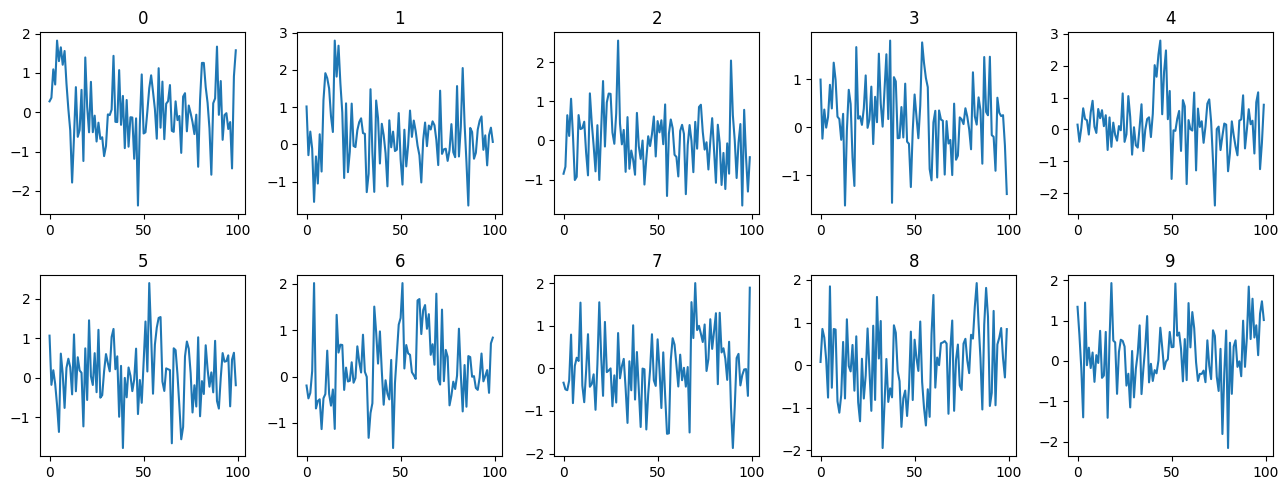

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
for label in range(10):
    plt.subplot(2, 5, label+1)
    vec = make_noise(1, torch.tensor([label])).cpu().ravel()
    plt.plot(vec)
    plt.title(label)
plt.tight_layout()

こう見るとわかり辛いが、移動平均をとるとしっかりと特徴が表れているのが分かる

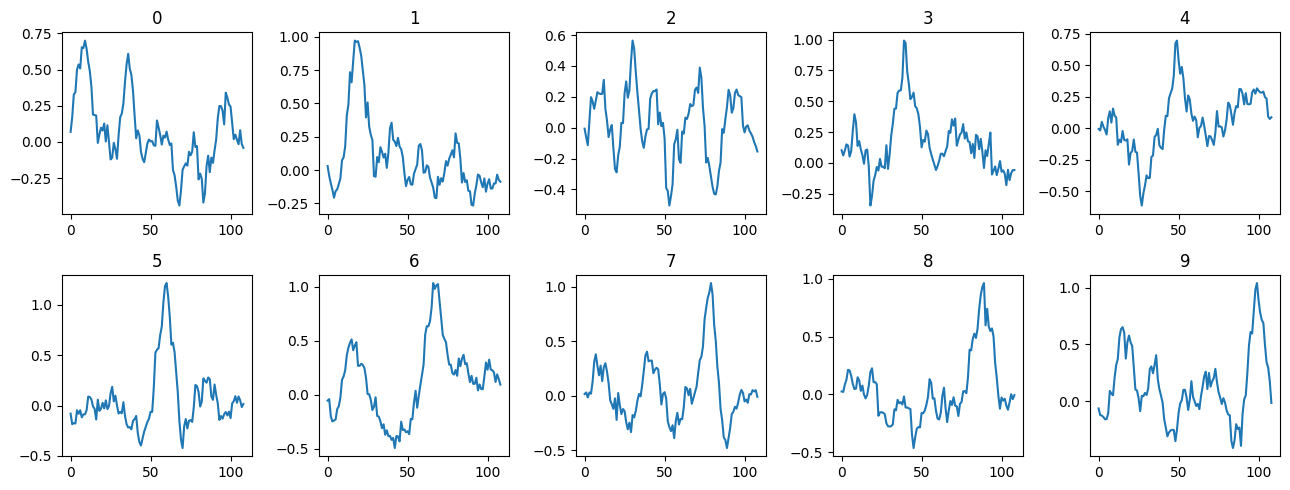

In [30]:
import numpy as np

plt.figure(figsize=(13, 5))
for label in range(10):
    plt.subplot(2, 5, label+1)
    vec = make_noise(1, torch.tensor([label])).cpu().numpy().ravel()
    vec = np.convolve(vec, np.ones(10)/10)
    plt.plot(vec)
    plt.title(label)
plt.tight_layout()

## 学習

In [5]:
def make_false_labels(labels):
    diff = torch.randint(1, n_classes, size=labels.size(), device=device)
    fake_labels = (labels + diff) % n_classes
    return fake_labels

In [6]:
def write1(netG, size=64):
    z = make_noise(10, torch.arange(10))
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, 10)
    img = transforms.functional.to_pil_image(img)
    display(img)

def write10(netG, size=64):
    z = make_noise(100, torch.arange(100) // 10)
    images = netG(z)
    images = transforms.Resize(size)(images)
    img = torchvision.utils.make_grid(images, 10)
    img = transforms.functional.to_pil_image(img)
    display(img)


In [7]:
fake_labels = torch.zeros(batch_size, 1).to(device)
real_labels = torch.ones(batch_size, 1).to(device)
criterion = nn.BCELoss()

def train(netD, netG, optimD, optimG, n_epochs, write_interval=1, progress=True, print_interval=1):
    netD.train()
    netG.train()
    for epoch in range(1, n_epochs+1):
        lossD_list = []
        lossG_list = []
        for X, labels in tqdm(dataloader, disable=not progress):
            X = X.to(device)
            labels = labels.to(device)
            false_labels = make_false_labels(labels)
            optimD.zero_grad()
            optimG.zero_grad()
            z = make_noise(batch_size, labels)
            fake = netG(z)

            pred_fake = netD(fake, labels)
            pred_real_true = netD(X, labels)
            pred_real_false = netD(X, false_labels)

            loss_fake = criterion(pred_fake, fake_labels)
            loss_real_true = criterion(pred_real_true, real_labels)
            loss_real_false = criterion(pred_real_false, fake_labels)

            lossD = loss_fake + loss_real_true + loss_real_false
            lossD.backward()
            optimD.step()

            fake = netG(z)
            pred = netD(fake, labels)
            lossG = criterion(pred, real_labels)
            lossG.backward()
            optimG.step()

            lossD_list.append(lossD.item())
            lossG_list.append(lossG.item())

        if print_interval and epoch % print_interval == 0:
            print(f'{epoch:>3}epoch | lossD: {lossD}, lossG: {lossG}')
        if write_interval and epoch % write_interval == 0:
            write1(netG)

  1epoch | lossD: 1.3281000852584839, lossG: 7.154473304748535
  2epoch | lossD: 1.0756022930145264, lossG: 5.081761837005615
  3epoch | lossD: 0.6729311943054199, lossG: 4.03178071975708
  4epoch | lossD: 0.5300643444061279, lossG: 3.2617671489715576
  5epoch | lossD: 0.5745236277580261, lossG: 3.7600324153900146


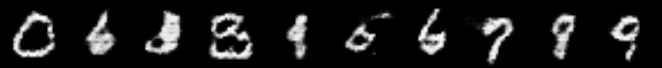

  6epoch | lossD: 0.47022581100463867, lossG: 3.7320165634155273
  7epoch | lossD: 0.7579953670501709, lossG: 2.5136055946350098
  8epoch | lossD: 0.6224940419197083, lossG: 2.0510356426239014
  9epoch | lossD: 1.1333749294281006, lossG: 1.6262764930725098
 10epoch | lossD: 1.0391713380813599, lossG: 1.5986297130584717


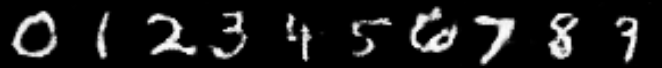

 11epoch | lossD: 0.7599163055419922, lossG: 2.0910863876342773
 12epoch | lossD: 0.9903641939163208, lossG: 1.6708183288574219
 13epoch | lossD: 1.3806308507919312, lossG: 1.944826602935791
 14epoch | lossD: 1.055055856704712, lossG: 1.4238643646240234
 15epoch | lossD: 1.0087412595748901, lossG: 1.7065322399139404


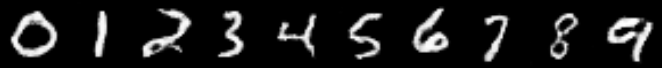

 16epoch | lossD: 0.983256995677948, lossG: 1.6144299507141113
 17epoch | lossD: 1.1290333271026611, lossG: 1.346123218536377
 18epoch | lossD: 1.1316516399383545, lossG: 1.348463773727417
 19epoch | lossD: 0.9062122106552124, lossG: 1.545655369758606
 20epoch | lossD: 1.1703264713287354, lossG: 1.1678489446640015


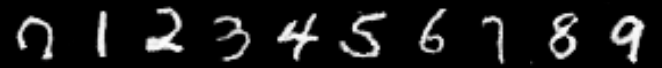

 21epoch | lossD: 1.000470519065857, lossG: 1.5600149631500244
 22epoch | lossD: 1.1580780744552612, lossG: 1.1815283298492432
 23epoch | lossD: 0.9144338369369507, lossG: 1.6108007431030273
 24epoch | lossD: 1.6054728031158447, lossG: 1.471548080444336
 25epoch | lossD: 1.1889327764511108, lossG: 1.3783049583435059


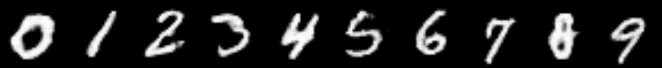

 26epoch | lossD: 1.19791579246521, lossG: 1.260457158088684
 27epoch | lossD: 0.8663791418075562, lossG: 1.5624427795410156
 28epoch | lossD: 1.2008084058761597, lossG: 1.3690199851989746
 29epoch | lossD: 1.0714755058288574, lossG: 1.6670500040054321
 30epoch | lossD: 1.0650649070739746, lossG: 1.4329315423965454


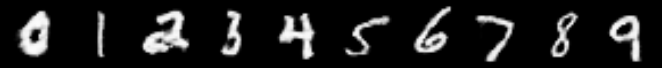

In [8]:
netD = Discriminator().to(device)
netG = Generator(nz).to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 30

train(netD, netG, optimD, optimG, n_epochs, 5, False)

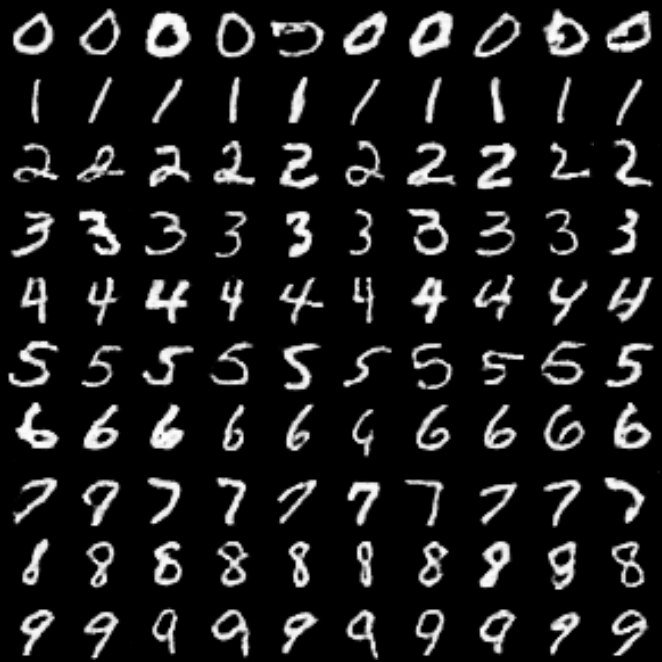

In [10]:
write10(netG)